<a href="https://colab.research.google.com/github/dlrg0987/Human-Action-Recognition-Project/blob/main/Transfer_Learning_Resnet_101V2_(CSP_JEDM)_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow-gpu

In [ ]:
!nvidia-smi # checking which GPU has been mounted (need to have Tesla T4 GPU mounted)
# To reselect GPU go to Runtime/Factory reset runtime and then rerun this cell to check if Tesla T4 has been allocated.


Tue Mar  9 10:34:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

In [ ]:
# re-size all the images to this
IMAGE_SIZE = (224, 224, 3)

train_path = '/content/drive/MyDrive/ES327- Individual Project/Datasets (CSP-JEDM)/Training'
valid_path = '/content/drive/MyDrive/ES327- Individual Project/Datasets (CSP-JEDM)/Cross Validation'


In [ ]:
# Import the Resnet library as shown below and add preprocessing layer to the front of RESNET 50
# Here we will be using imagenet weights

resnet = ResNet101V2(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)




171319296/171317808 [==============================] - 2s 0us/step


In [ ]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

In [ ]:
# useful for getting number of output classes
folders = glob('/content/drive/MyDrive/ES327- Individual Project/Datasets (CSP-JEDM)/Training/*')

In [ ]:
# our layers - you can add more if you want
x = Flatten()(resnet.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

### change made to add relgularization ###
from tensorflow.keras.regularizers import l2
# adding L2 regularization
regularizer = l2(l2=0.0001)
for layer in model.layers:
    for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)

In [ ]:

# view the structure of the model
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
# tell the model what cost and optimization method to use
adam_op = Adam(
    learning_rate=0.015, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
    )

model.compile(
  loss='categorical_crossentropy',
  #optimizer='adam',
  optimizer = adam_op,
  metrics=['accuracy']
)


In [ ]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   rotation_range = 90)

valid_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 shuffle = True,
                                                 class_mode = 'categorical')

Found 6685 images belonging to 10 classes.


In [ ]:
validation_set = valid_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            shuffle = True,
                                            class_mode = 'categorical')

Found 1732 images belonging to 10 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
105/105 [==============================] - 3133s 30s/step - loss: 137.9496 - accuracy: 0.2158 - val_loss: 91.9941 - val_accuracy: 0.2783
Epoch 2/200
105/105 [==============================] - 91s 863ms/step - loss: 109.0700 - accuracy: 0.3256 - val_loss: 107.2890 - val_accuracy: 0.2910
Epoch 3/200
105/105 [==============================] - 91s 863ms/step - loss: 114.6156 - accuracy: 0.3436 - val_loss: 102.2404 - val_accuracy: 0.2950
Epoch 4/200
105/105 [==============================] - 91s 863ms/step - loss: 109.4185 - accuracy: 0.3750 - val_loss: 134.2952 - val_accuracy: 0.2910
Epoch 5/200
105/105 [==============================] - 91s 864ms/step - loss: 109.6439 - accuracy: 0.3834 - val_loss: 121.1683 - val_accuracy: 0.2858
Epoch 6/200
105/105 [==============================] - 91s 867ms/step - loss: 107.9804 - accuracy: 0.4048 - val_loss: 120.7544 - val_accuracy: 0.3002
Epoch 7/200
105/105 [==============================] - 91s 861ms/step - loss: 115.5049 - accuracy: 0.

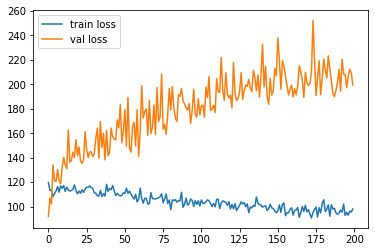

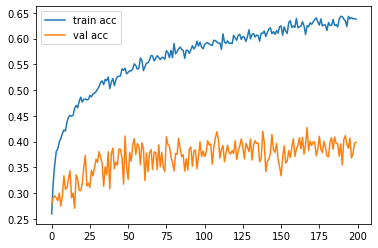

In [ ]:
#### fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=200,
  shuffle = True,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set)
)

#### plotting results and saving as png files
import matplotlib.pyplot as plt

# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/ES327- Individual Project/Learning Curves Plots/loss_learning_curve_ResNet101V2_V2_(200 epochs)_LR_0_015_shuffle_Batch64_L2_00001.png')
plt.show()


# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('/content/drive/MyDrive/ES327- Individual Project/Learning Curves Plots/accuracy_learning_curve_ResNet101V2_V2_(200 epochs)_LR_0_015_shuffle_Batch64_L2_00001.png')
plt.show()

#### save as a h5 file
from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/ES327- Individual Project/Trained Neural Networks/ResNet 101V2/model_resnet101V2_CSP_JEDM_V2_(200 epochs)_LR_0_015_shuffle_Batch64_L2_00001.h5')

In [ ]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/ES327- Individual Project/model_resnet50_CSP_JEDM_V2.h5')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale = 1./255)
test_path = '/content/drive/MyDrive/ES327- Individual Project/Datasets (CSP-JEDM)/Testing'
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 1013 images belonging to 10 classes.


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/ES327- Individual Project/Trained Neural Networks/ResNet 101V2/model_resnet101V2_CSP_JEDM_V2_(200 epochs)_LR_0_015_shuffle_Batch64_L2_00001.h5')

In [ ]:

y_pred = model.predict(test_set)
y_pred_prob = model.
y_eval = model.evaluate(test_set)


16/16 [==============================] - 161s 10s/step - loss: 494.7401 - accuracy: 0.3919


In [ ]:
y_pred = model.predict(test_set, verbose=0)
print(y_pred.shape)

(1013, 10)


In [ ]:
for i in range(20):
  print(y_pred[i,:])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 6.731821e-14 0.000000e+00]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0.         0.         0.         0.99272376 0.         0.
 0.         0.         0.00727628 0.        ]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.9707642e-25 0.0000000e+00]
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.9840735e-19]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.0000000e+00 0.0000000e+00 9.9972445e-01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 2.7553146e-04 0.0000000e+00 0.0000000e+00]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 

In [ ]:
import numpy as np
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
print(y_pred)

[8 7 4 ... 8 5 0]


In [ ]:
y_pred

[[11  3 12  4 13  8 13  9 21  7]
 [ 6  4  5  9  9 16 15 14 15  9]
 [13  5  6 12  9 10 11  7 18 11]
 [ 4  1 12  4 18 13 10 10 19  8]
 [ 6  3  5  7 25 12  7  9 14 13]
 [11  4  7  5 11 24  6 13 12  9]
 [11  7  8  7 16 21  4 10 10  8]
 [13  4  7 10 11 18 13  8 11  7]
 [10  7  5 10 12 11  9  9 11 18]
 [10  4  5  7 16 20 14  9  8  7]]
{'class_01': 0, 'class_06': 1, 'class_07': 2, 'class_08': 3, 'class_09': 4, 'class_24': 5, 'class_26': 6, 'class_27': 7, 'class_43': 8, 'class_59': 9}


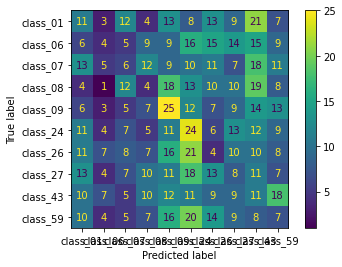

In [ ]:
#CODE TO OUTPUT CONFUSION MATRIX

from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_set.classes, y_pred)
print(cm)
print(test_set.class_indices)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = test_set.class_indices)
disp.plot() 

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [ ]:
model=load_model('model_resnet50.h5')

In [ ]:
img_data

In [ ]:
img=image.load_img('Datasets/Test/Coffee/download (2).jpg',target_size=(224,224))



In [ ]:
x=image.img_to_array(img)
x

In [ ]:
x.shape

In [ ]:
x=x/255

In [ ]:
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

In [ ]:
model.predict(img_data)

In [ ]:
a=np.argmax(model.predict(img_data), axis=1)

In [ ]:
a==1

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__